## Analysis of Ad Events

### Preliminaries before Analysis

In [30]:
# import necessary libraries
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# import data from csv files in data folder
path = os.getcwd()

ads = pd.read_csv(path + '/data/ads.csv')
campaigns = pd.read_csv(path + '/data/campaigns.csv')
users = pd.read_csv(path + '/data/users.csv')
events = pd.read_csv(path + '/data/ad_events.csv')

Like we discovered while doing EDA for events, we first have to remove the entries in users and events where the user id has been used for two different people. Doing so only removes about 1% of entires from both users and events and thus will have no significant impact on the data with regards to bias.

In [3]:
# find repeated user ids
temp = pd.DataFrame(users['user_id'].value_counts() > 1)
repeat_ids = list(temp[temp['count'] == True].index)

# update events and users to not contain rows with ids in repeat_ids
users = users[~users['user_id'].isin(repeat_ids)]
events = events[~events['user_id'].isin(repeat_ids)]

After removing these entries from the two tables we can now work on making on large dataframe containing the data from all four tables. This way one dataframe can be used for analyzing how ads performed with different demographics and how well each campaign performed, etc. It's important to note that from our EDA of ads we learned there are two campaigns that have no ads associated with them, campaigns 16 and 43. Rather than omitting those campaigns from the campaigns table, we'll keep them in to evaluate how two campaigns with no ads perform. Looking through the columns, the only updates which need to be done are changing the columns involving a datetime to pd.datetime object. Note the target_interests and user_interests columns contain some entries with a list of strings, but that will handled later when involving those columns. 

In [34]:
# first combine events with ads (column shared is ad_id)
temp = pd.merge(left = events, right = ads, how = 'inner', left_on = ['ad_id'], right_on = ['ad_id'])

# next combine temp with campaigns (column shared is campaign_id)
temp2 = pd.merge(left = temp, right = campaigns, how = 'inner', on = 'campaign_id')

# last combine temp2 with users (shared column is user_id)
df = pd.merge(left = temp2, right = users, how = 'inner', on = 'user_id')

# adjust names of select columns
df = df.rename(columns = {'name':'campaign_name', 'age_group':'user_age_group', 'country':'user_country',
                          'location':'user_location', 'interests':'user_interest'})

# change timestamp (of event), start_date (of campaign), and end_date (of compaign) to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

# show first five rows to ensure results
df.head()

,event_id,ad_id,user_id,timestamp,day_of_week,time_of_day,event_type,campaign_id,ad_platform,ad_type,...,start_date,end_date,duration_days,total_budget,user_gender,user_age,user_age_group,user_country,user_location,user_interest
0,1,197,2359b,2025-07-26 00:19:56,Saturday,Night,Like,9,Facebook,Stories,...,2025-05-25,2025-07-13,49,40094.07,Female,24,18-24,United States,West Shawna,"gaming, food"
1,2,51,f9c67,2025-06-15 08:28:07,Sunday,Morning,Share,26,Instagram,Carousel,...,2025-04-01,2025-06-17,77,44538.87,Female,30,25-34,United States,Meyersland,"photography, finance"
2,3,46,5b868,2025-06-27 00:40:02,Friday,Night,Impression,10,Instagram,Carousel,...,2025-05-17,2025-07-21,65,19669.27,Male,20,18-24,United States,Barrerahaven,"fashion, sports, travel"
3,4,166,3d440,2025-06-05 19:20:45,Thursday,Evening,Impression,14,Instagram,Image,...,2025-04-15,2025-06-04,50,39849.94,Female,18,18-24,United States,Lake Angelaland,"food, art"
4,5,52,68f1a,2025-07-22 08:30:29,Tuesday,Morning,Impression,2,Instagram,Stories,...,2025-04-16,2025-07-07,82,79342.41,Male,58,55-65,United Kingdom,Robinsonberg,"finance, lifestyle"


### Analysis

#### Engagement Levels (Calendar View)

In [10]:
# create a heatmap of impressions by day, put into calendar view 
# subset df for just timestamp and event_type
data = df[['timestamp', 'event_type']].copy()

# create new column extracting just the date from timestamp
data['date'] = data['timestamp'].dt.date

# remove timestamp column to keep just date
data = data.drop(columns = 'timestamp').sort_values(by = 'date')

In [11]:
# tally number of impressions and other events in data
event_tally = data.groupby(by = ['date', 'event_type']).size().reset_index(name = 'count')
event_counts = event_tally.pivot(index = 'date', columns = 'event_type', values = 'count')
event_counts.head()

event_type,Click,Comment,Impression,Like,Purchase,Share
date,,,,,,
2025-05-07,175,10,1544,62,7,9
2025-05-08,435,44,3684,144,28,19
2025-05-09,472,43,3773,113,19,15
2025-05-10,447,50,3695,132,17,19
2025-05-11,464,48,3739,128,26,14


In [12]:
# create functions to help plot calendar heatmap
def plot_heatmap(ax, dates, data):
    dates = list(dates)
    data = list(data)
    return calendar_heatmap(ax, dates, data)

def calendar_array(dates, data):
    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar

def calendar_heatmap(ax, dates, data):
    i, j, calendar = calendar_array(dates, data)
    im = ax.imshow(calendar, interpolation = 'none', cmap = 'summer')
    label_days(ax, dates, i, j, calendar)
    label_months(ax, dates, i, j, calendar)
    ax.figure.colorbar(im)

def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni,9))
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha = 'center', va = 'center')
    
    ax.set(xticks = np.arange(7),
           xticklabels = ['M', 'T', 'W', 'R', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

def label_months(ax, dates, i, j, calendar):
    month_labels = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    months = np.array([d.month for d in dates])
    unique_months = sorted(set(months))
    y_ticks = [i[months == m].mean() for m in unique_months]
    labels = [month_labels[m - 1] for m in unique_months]
    ax.set(yticks = y_ticks)
    ax.set_yticklabels(labels, rotation = 90)

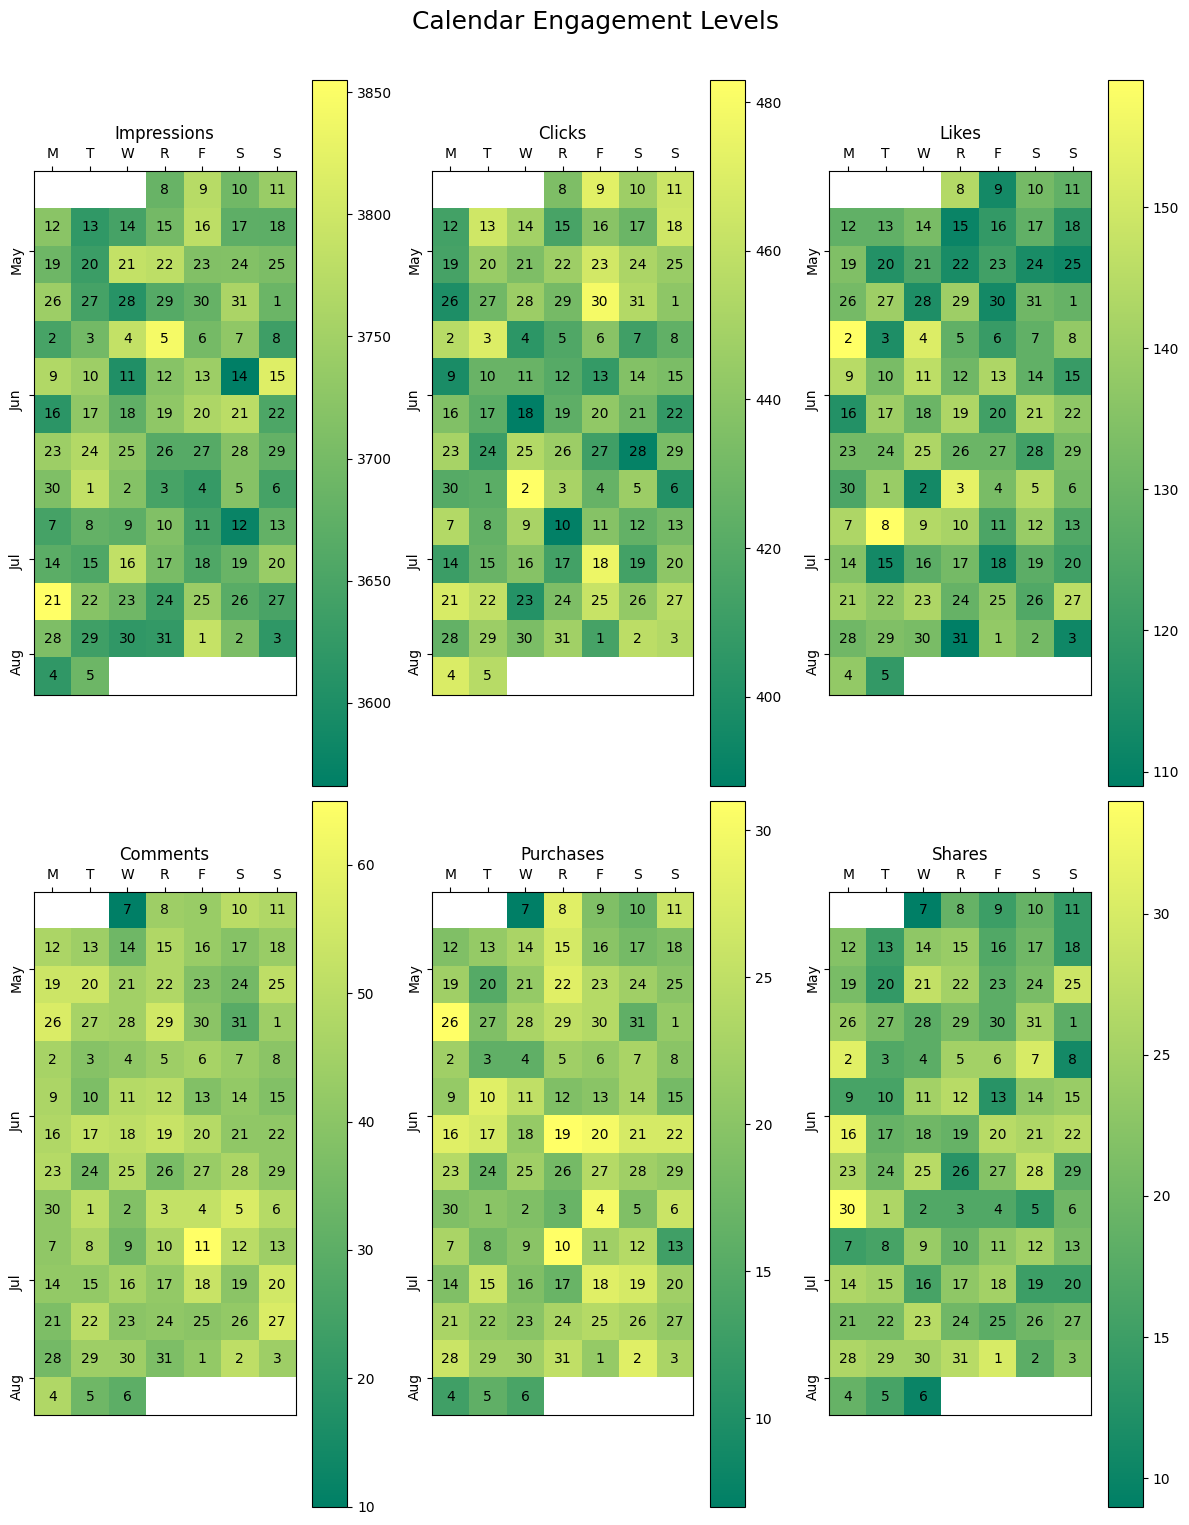

In [13]:
# combined visualization of heatmaps for each level of engagement
dates = event_counts.index

# create a single figure and plot all heatmaps as subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 16))
fig.suptitle("Calendar Engagement Levels", fontsize=18)

# impressions (omitted first and last day to show nuance of other days)
plot_heatmap(axes[0, 0], dates = dates[1:-1], data = event_counts['Impression'][1:-1])
axes[0, 0].set_title("Impressions")

# clicks
plot_heatmap(axes[0, 1], dates = dates[1:-1], data = event_counts['Click'][1:-1])
axes[0, 1].set_title('Clicks')

# likes
plot_heatmap(axes[0, 2], dates = dates[1:-1], data = event_counts['Like'][1:-1])
axes[0, 2].set_title('Likes')

# comments
plot_heatmap(axes[1, 0], dates = dates, data = event_counts['Comment'])
axes[1, 0].set_title('Comments')

# purchases
plot_heatmap(axes[1, 1], dates = dates, data = event_counts['Purchase'])
axes[1, 1].set_title('Purchases')

# shares
plot_heatmap(axes[1, 2], dates = dates, data = event_counts['Share'])
axes[1, 2].set_title('Shares')

plt.tight_layout(rect = [0, 0.03, 1, 0.97])
plt.show()

In [ ]:
# alter event_counts before saving results to csv file (in results directory)
# rename columns (adding s at the end)
event_counts = event_counts.rename(columns = {'Click':'Clicks', 'Comment':'Comments', 'Impression':'Impressions',
                                              'Like':'Likes', 'Purchase':'Purchases', 'Share':'Shares'})

# reorder columns to have larger numbers (on average) in front
event_counts = event_counts[['Impressions', 'Clicks', 'Likes', 'Comments', 'Purchases', 'Shares']]

In [ ]:
# save event_counts to csv "daily_interactions.csv"
event_counts.to_csv(path_or_buf = path + '/results/daily_interactions.csv', index = True)

#### Performance by Ad

In [14]:
# create table tallying number of each engagement for each ad_id
ad_events = df.filter(items = ['ad_id', 'event_type']).copy()
ad_tally = ad_events.groupby(by = ['ad_id', 'event_type']).size().reset_index(name = 'count')
ad_counts = ad_tally.pivot(index = 'ad_id', columns = 'event_type', values = 'count')
ad_counts.head()

event_type,Click,Comment,Impression,Like,Purchase,Share
ad_id,,,,,,
1,211,24,1731,56,8,8
2,204,23,1731,56,13,10
3,222,27,1634,67,13,8
4,197,30,1711,56,12,10
5,207,22,1678,59,11,8


One metric we can't include here is cost per click (CPC). The budget metric in campaigns only applied to the entire campaign with it being impossible to discern how much funding each ad within a campaign received. One possibility is to evenly divide a campaign budget among each of its ads but that could artifically increase some numbers without providing real world insight. Thus we will leave the factor of cost to analyzing campaigns.

In [ ]:
# create new table to update with ad metrics (CTR, etc.)
ad_metrics = ad_counts.copy()

# click through rate - the number of clicks divided by the number of impressions
ad_metrics['CTR'] = ad_metrics['Click'] / ad_metrics['Impression'] * 100

# engagement rate - sum of all non-impression metrics divided by the number of impressions 
temp = ad_metrics[['Click', 'Comment', 'Like', 'Purchase', 'Share']].copy().sum(axis = 1)
ad_metrics['ENGR'] = temp / ad_metrics['Impression'] * 100

# purchase rate - number of purchases divided by the number of clicks
ad_metrics['PURR'] = ad_metrics['Purchase'] / ad_metrics['Click'] * 100

# share rate - number of shares divided by the number of clicks 
ad_metrics['SHRR'] = ad_metrics['Share'] / ad_metrics['Click'] * 100

# sort the table by metrics (highest CTR, then ENGR, etc.)
ad_metrics = ad_metrics.sort_values(by = ['CTR', 'ENGR', 'PURR', 'SHRR'], ascending = False)

# show top ten ads (highest CTR followed by other metrics) 
ad_metrics.head()

event_type,Click,Comment,Impression,Like,Purchase,Share,CTR,ENGR,PURR,SHRR
ad_id,,,,,,,,,,
145,239,18,1631,52,4,9,14.653587,19.742489,1.673640,3.765690
61,218,20,1489,76,13,10,14.640698,22.632639,5.963303,4.587156
68,229,25,1600,67,15,13,14.312500,21.812500,6.550218,5.676856
29,221,22,1621,61,17,10,13.633560,20.419494,7.692308,4.524887
3,222,27,1634,67,13,8,13.586291,20.624235,5.855856,3.603604


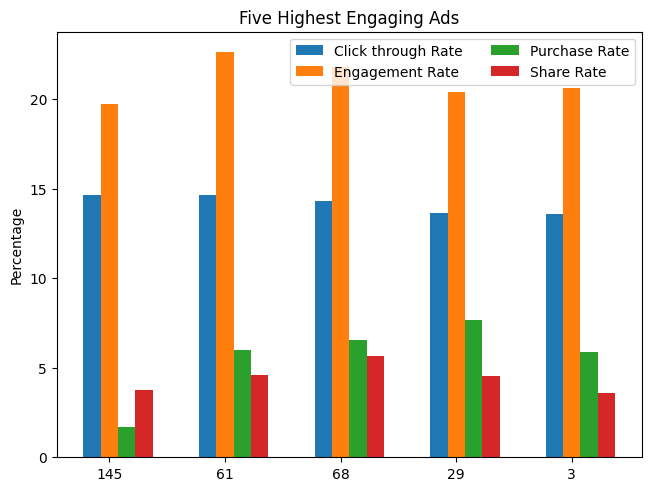

In [28]:
# plotting five highest performing ads
plotting_metrics = ad_metrics[['CTR', 'ENGR', 'PURR', 'SHRR']].copy().head(5)
ad_ids = plotting_metrics.index
metrics = plotting_metrics.to_dict(orient = 'list')

# barplot (order determined by highest CTR)
x = np.arange(len(plotting_metrics)) # location for labels
width = 0.15 # width of the bars in the plot
multiplier = 0

fig, ax = plt.subplots(layout = 'constrained')
for metric, value in metrics.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label = metric)
    multiplier += 1

# add other labels to graph
ax.set_ylabel('Percentage')
ax.set_title('Five Highest Engaging Ads')
ax.set_xticks(x + width, ad_ids)
legend_labels = ['Click through Rate', 'Engagement Rate', 'Purchase Rate', 'Share Rate']
ax.legend(loc = 'upper right', labels = legend_labels, ncols = 2)

plt.show()

In [ ]:
# make changes to ad_metrics before saving data to csv
# round metric columns to two decimal places for readability
ad_metrics[['CTR', 'ENGR', 'PURR', 'SHRR']] = round(ad_metrics[['CTR', 'ENGR', 'PURR', 'SHRR']], 2)

# rename and reorder columns for readability 
ad_metrics = ad_metrics.rename(columns = {'Click':'Clicks', 'Comment':'Comments', 'Impression':'Impressions',
                                          'Like':'Likes', 'Purchase':'Purchases', 'Share':'Shares',
                                          'CTR':'Click Through Rate', 'ENGR':'Engagement Rate',
                                          'PURR':'Purchase Rate', 'SHRR':'Share Rate'})
ad_metrics = ad_metrics[['Impressions', 'Clicks', 'Likes', 'Comments', 'Purchases', 'Shares',
                         'Engagement Rate', 'Click Through Rate', 'Purchase Rate', 'Share Rate']]

In [45]:
# save ad_metrics to csv metrics_by_ad.csv
ad_metrics.to_csv(path_or_buf = path + '/results/metrics_by_ad.csv', index = True)

TODO: Other metrics to calculate and look into
- 6aq 